# Nested CV vs other CV implementations

In [10]:
import pandas as pd
import numpy as np
import joblib

In [11]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Four variations of Repeated Cross-validation 

This notebook evaluates <mark>four variations of Repeated stratified k-fold cross-validation</mark>: 

1. <mark style='background-color: #FFDC9E; font-weight: bold'>30 repetitions of stratified 4-fold cross-validation (30x4cv) with default hyperparameters</mark>:
    - No hyperparameter tunning is performed. 
    - The scores from all validation folds are reported 
        - 120 scores in total.
        
2. <mark style='background-color: #EB9EAA; font-weight: bold'>30 repetitions of stratified 4-fold cross-validation (30x4cv) with preselected hyperparameters (see this [notebook](./1_Hyperparameter_tuning_stage.ipynb))</mark>:
    - No hyperparameter tunning is performed. 
    - The scores from all folds are reported 
        - 120 scores in total. 
    - This is the implementation which results are shown in the main manuscript. 
    
3. <mark style='background-color: #AECDC8; font-weight: bold'>30 repetitions of stratified nested 4-fold 4-fold cross-validation</mark>:
    - Hyperparameter tuning was performed in the inner loop (using the grid of hyperparameters from this [notebook](./1_Hyperparameter_tuning_stage.ipynb)). 
    - The evaluation was performed in the outer loop. 
    - The scores from all validation folds (outer loop) are reported.
        - 120 scores in total.
        
4. <mark style='background-color: #96C0E5; font-weight: bold'>30 repetitions of stratified grid search 4-fold cross-validation</mark>:
    - Hyperparameter tuning and evaluation were done over the same folds (using the grid of hyperparameters from this [notebook](./1_Hyperparameter_tuning_stage.ipynb)). 
    - Only the best score per repetition is reported.
        - 30 scores in total.

## Load the results

The results where obtained by implemented the following two scripts (see the code for the detailed implementation):
- Logistic Regression: [`lr_nested_cv_lr.py`](./nested_cv_results/lr_nested_cv_lr.py)
- Gradient Boosting Trees: [`xgb_nested_cv_lr.py`](./nested_cv_results/xgb_nested_cv_lr.py)

In [12]:
prot_name = 'fxa'

In [13]:
# Logistic Regression Results
df_LR = pd.read_csv(f'./nested_cv_results/DF1_{prot_name}_LR_30reps_4x4nCV_reesults.csv', index_col = 0)
# Gradient Boosting Trees
df_GBT = pd.read_csv(f'./nested_cv_results/DF1_{prot_name}_XGB_30reps_4x4nCV_results.csv', index_col = 0)

In [14]:
df_LR.describe().T

,count,mean,std,min,25%,50%,75%,max
nested,120.0,0.827938,0.023927,0.777946,0.814381,0.826622,0.844900,0.881564
non_nested,120.0,0.831203,0.004727,0.822453,0.827497,0.831177,0.835442,0.841857
preOptHpm,120.0,0.826568,0.024015,0.761304,0.812452,0.826419,0.842092,0.883064
defHpm,120.0,0.831192,0.023538,0.777946,0.815000,0.832394,0.848159,0.886226


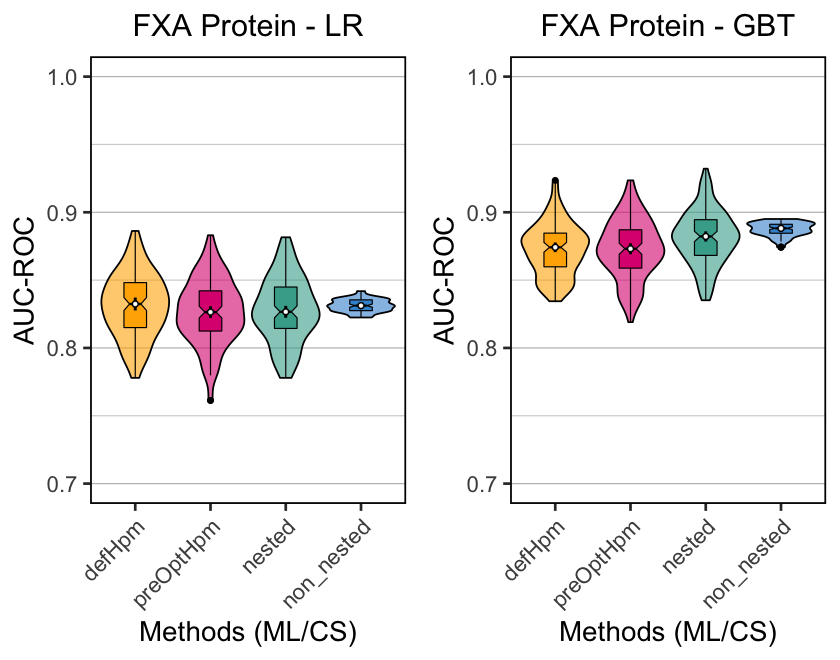

In [15]:
%%R  -i df_LR -i df_GBT -i prot_name -w 4.2 -h 3.3 --units in -r 200

library(cowplot)
source('../../R_scripts/plot_violinBox.R')
cbbPalette <- c( '#FFB000', '#DC267F', '#44AA99', '#3F93D2')
prot_name = toupper(prot_name)


names_order = c("defHpm", "preOptHpm", "nested", "non_nested")

# Logistic Regression
p_1 = plot_violin(df = df_LR, 
                cbbPalette = cbbPalette,
                decreasing_order = TRUE, 
                y_min=0.7, y_max=1,
                dot_size = 4, scale='width', 
                violin_width=0.9,
                names_order = names_order) +
ggtitle(paste(prot_name, 'Protein - LR'))

# Gradient Boosting Trees
p_2 = plot_violin(df = df_GBT, 
                cbbPalette = cbbPalette,
                decreasing_order = TRUE, 
                y_min=0.7, y_max=1,
                dot_size = 4, scale='width', 
                violin_width=0.9,
                names_order = names_order) +
ggtitle(paste(prot_name, 'Protein - GBT')) 

plot_grid(p_1, p_2, 
          labels = 'XXX', label_y = 1.5, 
          rel_heights = c(1,0.5))

## Results per repetition

In [16]:
# Logistic Regression Results
df_LR_means = pd.read_csv(f'./nested_cv_results/DF2_MEANS_{prot_name}_LR_30reps_4x4nCV_reesults.csv', index_col = 0)
# Gradient Boosting Trees
df_GBT_means = pd.read_csv(f'./nested_cv_results/DF2_MEANS_{prot_name}_XGB_30reps_4x4nCV_results.csv', index_col = 0)

### Logistic Regression Results

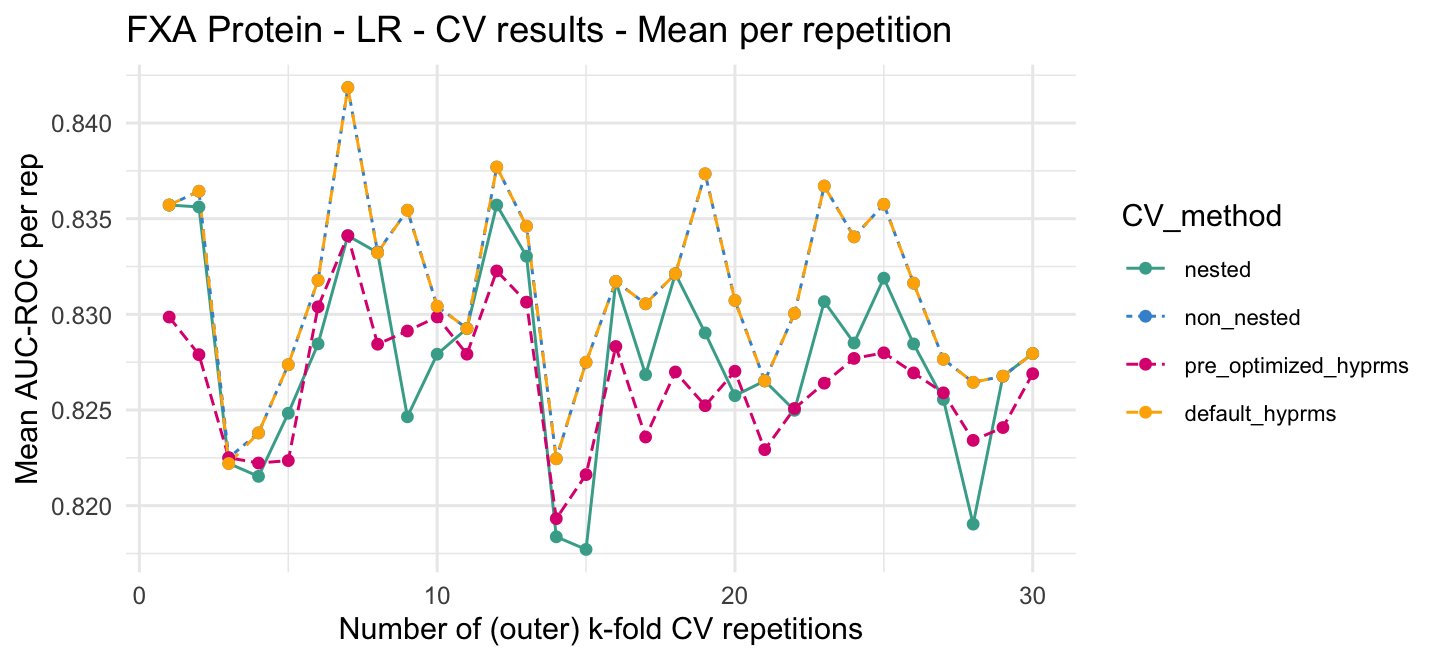

In [17]:
%%R -i df_LR_means -w 7.2 -h 3.3 --units in -r 200
# Load the source file
library(reshape2)
source('../../R_scripts/plot_violinBox.R')

cbbPalette <- c('#44AA99', '#3F93D2', '#DC267F', '#FFB000')
df <- df_LR_means
df$repetition <- c(1:dim(df)[1])
df <- melt(df, variable.name = 'CV_method', id = c('repetition'))
ggplot(data=df, aes(x=repetition, y=value, group=CV_method)) +
  geom_line(aes(color=CV_method, linetype = CV_method)) +
  geom_point(aes(color=CV_method)) + 
  scale_color_manual(values=cbbPalette) +
  xlab("Number of (outer) k-fold CV repetitions") + ylab("Mean AUC-ROC per rep") +
  theme_minimal() + 
  theme(legend.text=element_text(size=8)) +
  ggtitle(paste(prot_name, 'Protein - LR - CV results - Mean per repetition')) 


## Gradient Boosting Trees

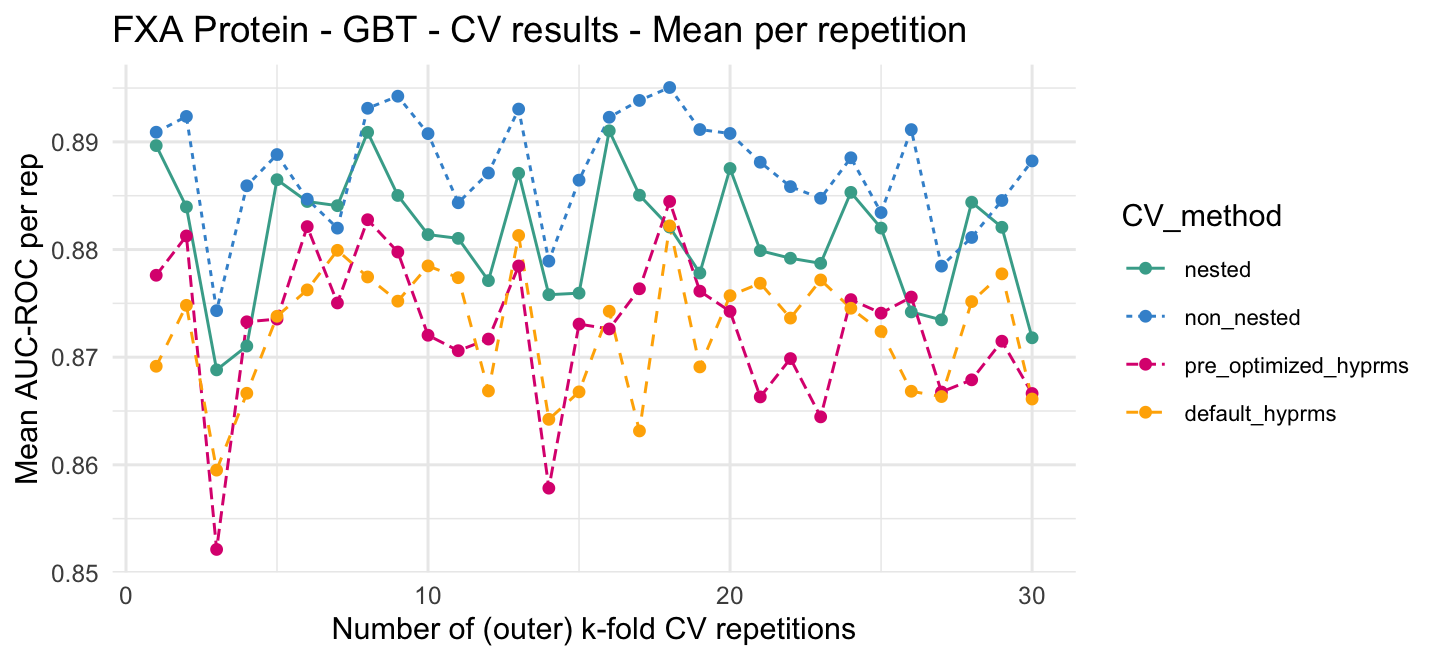

In [18]:
%%R -i df_GBT_means -w 7.2 -h 3.3 --units in -r 200
# Load the source file
library(reshape2)
source('../../R_scripts/plot_violinBox.R')

cbbPalette <- c('#44AA99', '#3F93D2', '#DC267F', '#FFB000')
df <- df_GBT_means
df$repetition <- c(1:dim(df)[1])
df <- melt(df, variable.name = 'CV_method', id = c('repetition'))
ggplot(data=df, aes(x=repetition, y=value, group=CV_method)) +
  geom_line(aes(color=CV_method, linetype = CV_method)) +
  geom_point(aes(color=CV_method)) + 
  scale_color_manual(values=cbbPalette) +
  xlab("Number of (outer) k-fold CV repetitions") + ylab("Mean AUC-ROC per rep") +
  theme_minimal() + 
  theme(legend.text=element_text(size=8)) +
  ggtitle(paste(prot_name, 'Protein - GBT - CV results - Mean per repetition')) 
